In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import models,layers

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [17]:
# import h5py
# import pandas as pd
# emotion_df = h5py.File('/content/drive/MyDrive/Facial Expression Detection/Live-facial-emotion-detection-main/fer_model.h5')
# df = pd.DataFrame(np.array(emotion_df))

emotion_df=pd.read_csv('/content/drive/MyDrive/Facial Expression Detection/Live-facial-emotion-detection-main/fer2013.csv')


In [18]:
emotion_df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


**Given pixels of each images is in string form!**

In [20]:
emotion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [21]:
emotion_df.shape

(35887, 3)

**Emotion label**<br>
0-Angry<br>
1-Disgust<br>
2-Fear<br>
3-Happy<br>
4-Sad<br>
5-Surprise<br>
6-Neutral


In [22]:
emotion_df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [23]:
#Lets remove Disgust and Fear label and make just  5 labels
drop_rows=emotion_df[(emotion_df.emotion==1) | (emotion_df.emotion==2)]
emotion_df=emotion_df.drop(drop_rows.index)

In [24]:
train_df=emotion_df[emotion_df['Usage']=='Training']
test_df=emotion_df[emotion_df['Usage']=='PrivateTest']

In [25]:
def split_x_y(df):
  x=[]
  img_pxl=df['pixels'].values
  for image in img_pxl:
      image=np.array(image.split(' '))
      image=(image.reshape(48,48,1)).astype('float')
      x.append(image)
  
  X=np.array(x)
  X=X/225
  Y=df['emotion'].values

  return X,Y

x_train,y_train=split_x_y(train_df)
x_test,y_test=split_x_y(test_df) 

In [26]:
y_train=pd.get_dummies(y_train).values
y_test_oh=pd.get_dummies(y_test).values

In [27]:
model=models.Sequential()
model.add(layers.Conv2D(64,(3,3),input_shape=(48,48,1)))
model.add(layers.Conv2D(64, (3, 3), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128,(3,3),padding='same'))
model.add(layers.Conv2D(128, (3, 3), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128,(3,3)))
model.add(layers.Conv2D(64, (3, 3), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256,(3,3),padding='same'))
model.add(layers.Conv2D(256,(3,3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
#model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5,activation='softmax'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0

In [29]:
optimizer=tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [31]:
history=model.fit(x_train,y_train,batch_size=64,epochs=6,validation_data=(x_test,y_test_oh))

Epoch 1/6
378/378 [==============================] - 16s 41ms/step - loss: 1.1964 - accuracy: 0.5137 - val_loss: 1.1294 - val_accuracy: 0.5359
Epoch 2/6
378/378 [==============================] - 15s 38ms/step - loss: 1.0869 - accuracy: 0.5677 - val_loss: 1.3365 - val_accuracy: 0.4731
Epoch 3/6
378/378 [==============================] - 15s 38ms/step - loss: 1.0321 - accuracy: 0.5918 - val_loss: 1.0053 - val_accuracy: 0.6198
Epoch 4/6
378/378 [==============================] - 15s 39ms/step - loss: 0.9837 - accuracy: 0.6154 - val_loss: 0.9890 - val_accuracy: 0.6158
Epoch 5/6
378/378 [==============================] - 14s 38ms/step - loss: 0.9557 - accuracy: 0.6279 - val_loss: 1.0072 - val_accuracy: 0.5948
Epoch 6/6
378/378 [==============================] - 14s 38ms/step - loss: 0.9273 - accuracy: 0.6427 - val_loss: 0.9419 - val_accuracy: 0.6058


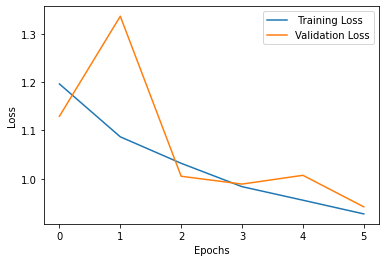

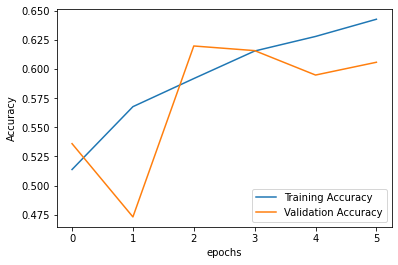

In [32]:
accuracy=history.history['accuracy']
loss=history.history['loss']
val_accuracy=history.history['val_accuracy']
val_loss=history.history['val_loss']
epochs=[x for x in range(len(accuracy))]
#plot Loss
plt.plot(epochs,loss,label=' Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plot Accuracy
plt.plot(epochs,accuracy,label='Training Accuracy')
plt.plot(epochs,val_accuracy,label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
model.evaluate(x_test,y_test_oh)

94/94 [==============================] - 1s 9ms/step - loss: 0.9419 - accuracy: 0.6058


[0.9419139623641968, 0.6057884097099304]

In [34]:
y_pred=model.predict_classes(x_test)

AttributeError: ignored

In [35]:
model.save('/content/drive/MyDrive/Colab Notebooks/Emotion Recognition/fr_model.h5')